# BBC News Classification
BBC News classification competition is based on a public data from BBC comprised of 2225 articles, each labeled under one of 5 categories: business, entertainment, politics, sport or tech.

The dataset is broken into 1490 records for training and 735 for testing. The goal is to build a system that can accurately classify previously unseen news articles into the right category.

Also the evaluation metric used is "Accuracy".

The data can be downloaded from the URL below:
https://www.kaggle.com/competitions/learn-ai-bbc/data

# 1. Importing libraries

In [1]:
#import libraries
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import os
from time import time
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF

# 2. Importing data and EDA

In [2]:
path_dir = 'learn-ai-bbc/'
train_path = path_dir + 'BBC News Train.csv'
sample_solution_path = path_dir + 'BBC News Sample Solution.csv'
test_path = path_dir + 'BBC News Test.csv'

train = pd.read_csv(train_path)
sample_solution = pd.read_csv(sample_solution_path)
test = pd.read_csv(test_path)

In [3]:
train.head(20)

,ArticleId,Text,Category
0,1833,worldcom ex-boss launches defence lawyers defe...,business
1,154,german business confidence slides german busin...,business
2,1101,bbc poll indicates economic gloom citizens in ...,business
3,1976,lifestyle governs mobile choice faster bett...,tech
4,917,enron bosses in $168m payout eighteen former e...,business
5,1582,howard truanted to play snooker conservative...,politics
6,651,wales silent on grand slam talk rhys williams ...,sport
7,1797,french honour for director parker british film...,entertainment
8,2034,car giant hit by mercedes slump a slump in pro...,business
9,1866,fockers fuel festive film chart comedy meet th...,entertainment


In [189]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1490 entries, 0 to 1489
Data columns (total 3 columns):
ArticleId    1490 non-null int64
Text         1490 non-null object
Category     1490 non-null object
dtypes: int64(1), object(2)
memory usage: 35.0+ KB


<b>'Text' is the main input unstructured data that we will be training on. 'Category' is what needs to be predicted. Let's perform some analysis on the 'Category' column to see how many unique categories are there and what's their distribution in this training data set.<b>

In [190]:
train.Category.unique()

array(['business', 'tech', 'politics', 'sport', 'entertainment'],
      dtype=object)

In [191]:
category_df = train.groupby('Category').count()
print(category_df)

               ArticleId  Text
Category                      
business             336   336
entertainment        273   273
politics             274   274
sport                346   346
tech                 261   261


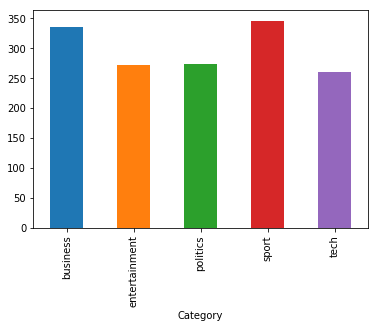

In [192]:
train.groupby('Category').Category.count().plot.bar(ylim=0)

<b>There are 5 types of categories in the dataset and by their respective counts, they look almost balanced in their distribution which is good. </b>

## 2.1 Text cleaning and standardization
For any NLP task, it's important to clean and standardize text and one of the most common things is to convert to lowercase and remove punctuation characters. Additionally we can remove stopwords which are common words that don't add any value and use techniques like stemming or lemmatization to standardize similar words to their root form.

In [193]:
# Text cleaning and normalization
import re
import nltk.corpus
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer


def cleanText(text):
    text = re.sub(r'[^\w\s]', '', str(text).lower().strip())
    stop = stopwords.words('english')
    lemmatizer = WordNetLemmatizer()
    text = " ".join([lemmatizer.lemmatize(word) for word in text.split() if word not in (stop)])
    return text


train.loc[:,'Clean_Text'] = train.apply(lambda row: cleanText(row['Text']), axis=1)
train.loc[:,'Word_Count'] = train.apply(lambda row: len(row['Clean_Text'].split()), axis=1)

train.head()

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\adi\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,ArticleId,Text,Category,Clean_Text,Word_Count
0,1833,worldcom ex-boss launches defence lawyers defe...,business,worldcom exboss launch defence lawyer defendin...,191
1,154,german business confidence slides german busin...,business,german business confidence slide german busine...,203
2,1101,bbc poll indicates economic gloom citizens in ...,business,bbc poll indicates economic gloom citizen majo...,292
3,1976,lifestyle governs mobile choice faster bett...,tech,lifestyle governs mobile choice faster better ...,353
4,917,enron bosses in $168m payout eighteen former e...,business,enron boss 168m payout eighteen former enron d...,211


(array([854., 522.,  98.,  10.,   2.,   1.,   0.,   2.,   0.,   1.]),
 array([  48. ,  212.7,  377.4,  542.1,  706.8,  871.5, 1036.2, 1200.9,
        1365.6, 1530.3, 1695. ]),
 <a list of 10 Patch objects>)

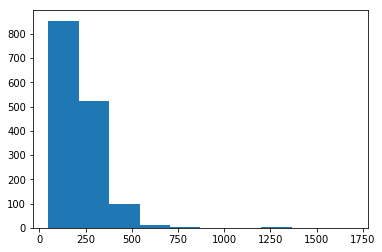

In [194]:
plt.hist(train.Word_Count)

In [211]:
# filter out rows > 500
len(train[train.Word_Count < 500])
print(len(train))

1469


As we can see out of 1490 total documents, 1469 are less than 500 words, we could filter out the rest but will keep them for now.

In [195]:
# we need to convert/map the Category column which is an object type to corresponding numeric calues for algorithms to process.
possible_labels = train['Category'].unique()
# Generate a dict mapping every Cateogry  to an id
label_dict = {}
for index, possible_label in enumerate(possible_labels):
    label_dict[possible_label] = index
    

# Get a new encoded category column (category_id)
train['category_id'] = train.Category.map(label_dict)

train.head(20)

,ArticleId,Text,Category,Clean_Text,Word_Count,category_id
0,1833,worldcom ex-boss launches defence lawyers defe...,business,worldcom exboss launch defence lawyer defendin...,191,0
1,154,german business confidence slides german busin...,business,german business confidence slide german busine...,203,0
2,1101,bbc poll indicates economic gloom citizens in ...,business,bbc poll indicates economic gloom citizen majo...,292,0
3,1976,lifestyle governs mobile choice faster bett...,tech,lifestyle governs mobile choice faster better ...,353,1
4,917,enron bosses in $168m payout eighteen former e...,business,enron boss 168m payout eighteen former enron d...,211,0
5,1582,howard truanted to play snooker conservative...,politics,howard truanted play snooker conservative lead...,158,2
6,651,wales silent on grand slam talk rhys williams ...,sport,wale silent grand slam talk rhys williams say ...,191,3
7,1797,french honour for director parker british film...,entertainment,french honour director parker british film dir...,134,4
8,2034,car giant hit by mercedes slump a slump in pro...,business,car giant hit mercedes slump slump profitabili...,281,0
9,1866,fockers fuel festive film chart comedy meet th...,entertainment,fockers fuel festive film chart comedy meet fo...,155,4


In [127]:
print(label_dict)

{'business': 0, 'tech': 1, 'politics': 2, 'sport': 3, 'entertainment': 4}


# 3. Model training 
## 3.1 Text Preprocessing (TF-IDF) and Unsupervised learning using NMF
Before we can feed raw text to any of the algorithms we need to convert it into numeric encodings. There are various approaches to do that like the basic ngram one-hot binary encodings or the one we are considering here which is the TF-IDF encodings (TF-IDF stands for "term frequency, inverse document frequency".) which takes into account the normalized counts/occurrences of the words in the entire dataset.<br>
As per assignment requirement, we will use the Non-Negative Matrix Factorization (NMF) algorithm to build the model and check it's accuracy on the training and test sets.


In [205]:
import scipy
from sklearn.metrics import accuracy_score
import itertools

n_components = 5 # for 5 categories
n_top_words = 20
batch_size = 128
init = "nndsvda"    


def label_permute_compare(ytdf,yp,n=5):
    """
    ytdf: labels dataframe object
    yp: clustering label prediction output
    Returns permuted label order and accuracy. 
    Example output: (3, 4, 1, 2, 0), 0.74 
    """
    labelorder=[]
    real_labels = []
    real_labels = train['category_id'].values
    for i in range(n):
        idx = yp == i
        new_label=scipy.stats.mode(real_labels[idx])[0][0]  # Choose the most common label among data points in the cluster
        labelorder.append(new_label)
    
    new_labels = [ labelorder[label] for label in yp]
    acc=accuracy_score(real_labels, new_labels)
    return tuple(labelorder), acc


def predict_topics(nmf, tfidf):
    # get the transformed matrix
    trans_matrix = nmf.transform(tfidf)
    print('trans_matrix shape:',trans_matrix.shape)
    print(trans_matrix)
    print('sorted matrix:')
    sorted_topic_matrix = np.argsort(trans_matrix)
    print(sorted_topic_matrix)
    n_predictions, maxValue = sorted_topic_matrix.shape
    predictions = [[sorted_topic_matrix[i][maxValue - 1]] for i in range(n_predictions)]
    topic_preds = np.array(predictions).reshape(-1,1).flatten()
    return topic_preds
    
# Use tf-idf features for NMF.
print("Extracting tf-idf features for NMF...")
#tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, norm = 'l2', stop_words="english")
tfidf_vectorizer = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 1), stop_words='english')

t0 = time()
tfidf = tfidf_vectorizer.fit_transform(train.Clean_Text)
print("done in %0.3fs." % (time() - t0))

# Fit the NMF model
print("Fitting the NMF model (kullback-leibler) with tf-idf features")

t0 = time()
nmf = NMF(
    n_components=n_components,
    random_state=1,
    init=init,
    beta_loss="kullback-leibler",
    solver="mu",
    l1_ratio=0.5,
).fit(tfidf)


print("done in %0.3fs." % (time() - t0))

topic_preds = predict_topics(nmf, tfidf)
labelorder, acc = label_permute(train, topic_preds)
print('best topic order:',labelorder, ', accuracy:', acc)



Extracting tf-idf features for NMF...
done in 0.415s.
Fitting the NMF model (Frobenius norm) with tf-idf features
done in 5.883s.
trans_matrix shape: (1490, 5)
[[2.30663574e-02 6.62950770e-09 1.23034658e-02 2.27277729e-03
  8.26608880e-02]
 [1.12039686e-08 2.67441050e-12 3.74520274e-05 1.16392424e-15
  1.33235955e-01]
 [8.80386123e-03 2.67379544e-06 4.86425791e-02 5.85428737e-07
  8.46441429e-02]
 ...
 [1.09137055e-09 1.05557110e-10 1.14685098e-09 3.79549905e-11
  1.15045713e-01]
 [1.60474647e-01 1.60835858e-05 9.71315099e-09 5.04146620e-05
  1.21338603e-03]
 [1.19016789e-01 3.39628863e-08 2.77730743e-10 1.51447826e-14
  4.87100371e-04]]
sorted matrix:
[[1 3 2 0 4]
 [3 1 0 2 4]
 [3 1 0 2 4]
 ...
 [3 1 0 2 4]
 [2 1 3 4 0]
 [3 2 1 4 0]]
best topic order: (1, 3, 2, 4, 0) , accuracy: 0.9463087248322147


### 3.1.1 Topic visualization based on the model results
As a sanity check, it would be good to see what are the top words the NMF model is selecting per topic/category.

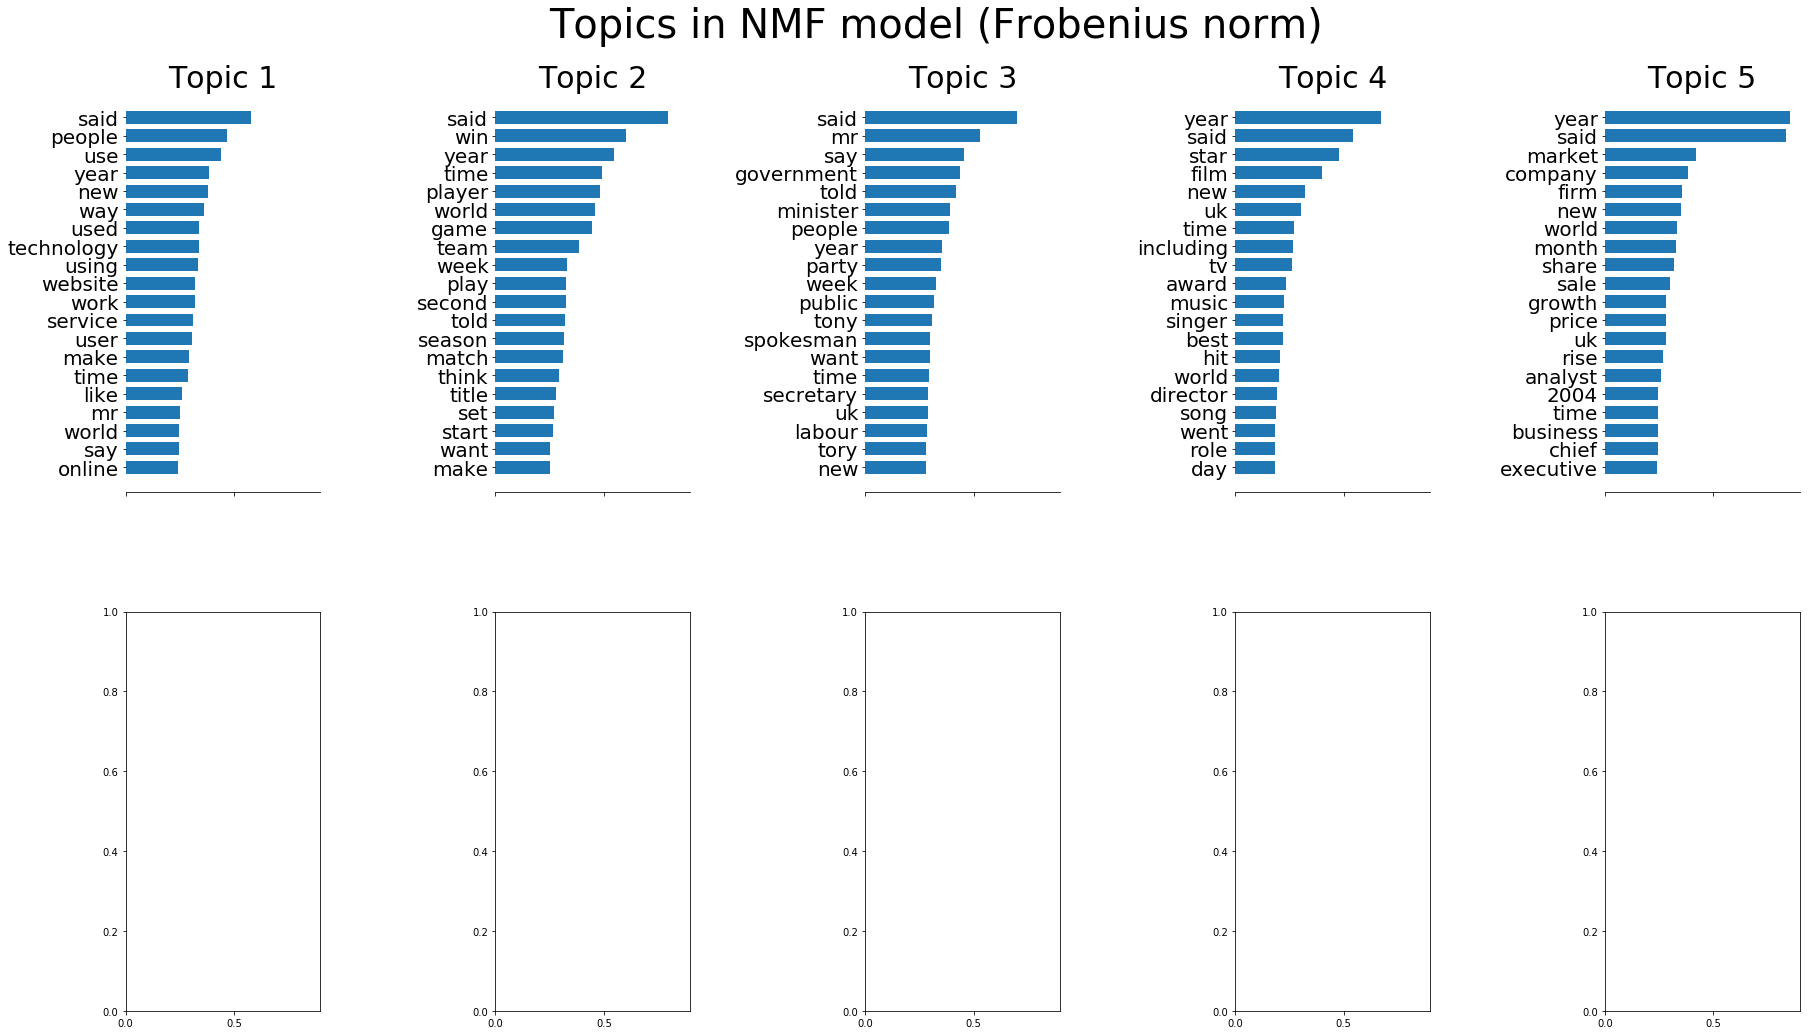

In [198]:
def plot_top_words(model, feature_names, n_top_words, title):
    fig, axes = plt.subplots(2, 5, figsize=(30, 15), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[: -n_top_words - 1 : -1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f"Topic {topic_idx +1}", fontdict={"fontsize": 30})
        ax.invert_yaxis()
        ax.tick_params(axis="both", which="major", labelsize=20)
        for i in "top right left".split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=40)

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()
    
tfidf_feature_names = tfidf_vectorizer.get_feature_names()
plot_top_words(
    nmf, tfidf_feature_names, n_top_words, "Topics in NMF model (kullback-leibler)"
)





Based on the above visualization, we can see the top 20 words for each topic and from those words one can visually validate that the model makes sense. For the best model: <br>
Topic 1(0) is same as Category 1 (tech) <br>
Topic 2(1) is same as Category 3 (sports) <br>
Topic 3(2) is same as Category 2 (politics) <br>
Topic 4(3) is same as Category 4 (sports) <br>
Topic 5(4) is same as Category 0 (business) <br>

In [206]:
# test data processing and submission

# clean test data
test.loc[:,'Clean_Text'] = test.apply(lambda row: cleanText(row['Text']), axis=1)

# same tfidf vectorizer is used that was fit on train set
tfid_test = tfidf_vectorizer.transform(test['Clean_Text'])
topic_preds_test = predict_topics(nmf, tfid_test)
print(topic_preds_test)

trans_matrix shape: (735, 5)
[[2.07283139e-12 6.95598962e-02 2.81171888e-03 9.97830645e-03
  6.39793164e-09]
 [1.18440027e-01 2.27241687e-11 2.41154383e-02 1.21730239e-08
  5.28909993e-07]
 [2.08903012e-03 1.05976861e-01 1.76389211e-03 2.30641414e-07
  1.35893299e-03]
 ...
 [3.33696672e-02 1.05979668e-02 4.75454999e-02 4.76129993e-03
  2.65221490e-02]
 [6.83867247e-07 3.12493521e-03 2.72103494e-02 1.31324807e-11
  6.66056305e-02]
 [1.11812073e-02 1.14859047e-05 1.16372692e-01 5.99074501e-03
  1.48001196e-02]]
sorted matrix:
[[0 4 2 3 1]
 [1 3 4 2 0]
 [3 4 2 0 1]
 ...
 [3 1 4 0 2]
 [3 0 1 2 4]
 [1 3 0 4 2]]
[1 0 1 4 1 1 2 2 3 4 4 0 2 0 3 1 2 0 3 0 4 2 1 4 2 1 4 1 1 4 2 0 4 4 1 1 1
 4 3 2 2 2 3 0 1 3 3 4 2 4 2 4 4 4 0 2 0 3 1 0 1 3 0 2 4 3 1 0 1 1 0 1 4 2
 0 1 0 0 0 3 2 1 3 3 2 3 4 3 4 0 2 2 1 0 1 1 1 1 1 1 2 1 2 3 4 1 2 1 2 3 1
 4 3 1 2 1 2 1 2 4 3 4 3 4 0 1 4 3 4 3 4 2 2 0 4 4 2 0 3 1 4 0 1 3 2 1 1 3
 3 0 4 0 2 3 1 1 1 1 3 0 4 0 4 0 4 3 3 0 0 2 4 2 4 4 3 2 0 4 4 0 1 2 1 2 0
 0 2 4 2 0 

In [209]:
# create submission
model_topic_dict = { 0:'tech', 1:'sports', 2:'politics', 3:'entertainment', 4:'business'}
submission_df = pd.DataFrame(columns=['ArticleId', 'Category', 'topic_preds'])
submission_df['ArticleId'] = test['ArticleId']
submission_df['topic_preds'] = topic_preds_test
submission_df['Category'] = submission_df['topic_preds'].apply(lambda i: model_topic_dict[i])

submission_df = submission_df.drop('topic_preds', axis=1)
submission_df.to_csv('submissionBBC_Final.csv', index=False)

Although the training set accuracy was 0.9463, with the test set submission got scores of 0.7075(Public) and 0.7075(Private), given an unsupervised learning algorithm being used this is something we can expect. But we will get more clarity on this once we model with respect to supervised learning algorithms and evaluate and compare those results.

## 3.2 Comparison with Supervised training models 
### 3.2.1 Linear, Tree, KNN models
It will be interesting to see how supervised learning models will perform so we take few popular models and evaluate the dataset on them. Also we will take this opportunity to perform cross validation which is a data resampling method to ensure that our models are generalizing well to new datasets on which prediction will be done.

In [128]:
# import classifiers for supervised training
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import RidgeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score

tfidf_vectorizer = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 1), stop_words='english')
X_train = tfidf_vectorizer.fit_transform(train.Clean_Text)
y_train = train['category_id']

N_FOLDS = 5

models = [('LR', LogisticRegression(n_jobs=-1)),
           ('SGD', SGDClassifier(n_jobs=-1)),
           ('Ridge', RidgeClassifier()), 
           ('MultinomialNB', MultinomialNB()), 
           ('SVM', SVC()),
           ('RandomForest', RandomForestClassifier(n_estimators=200)), 
           ('KNN', KNeighborsClassifier(n_neighbors=5))]

for (model_name, model) in models:
    
    # perform cross-validation
    scores = cross_val_score(model, X_train, y_train, cv=N_FOLDS)
    print('Running model: ' + model_name + ', mean accuracy: %.5f +/- %.5f' % (np.mean(scores), np.std(scores)))
    

# RidgeClassifier gave the best results so we will use that to make the submission
best_model = RidgeClassifier()
best_model.fit(X_train, y_train)

# predict for test set
test.loc[:,'Clean_Text'] = test.apply(lambda row: cleanText(row['Text']), axis=1)
tfid_test = tfidf_vectorizer.transform(test['Clean_Text'])
topic_preds_rc_test = best_model.predict(tfid_test)
print(topic_preds_rc_test)


D:\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
D:\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
D:\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1297: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
D:\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1297: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
D:\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1297: UserWarning: 'n_jobs' > 1 does not have any effect when

Running model: LR, mean accuracy: 0.97384 +/- 0.00645
Running model: SGD, mean accuracy: 0.98124 +/- 0.00743
Running model: Ridge, mean accuracy: 0.98055 +/- 0.00488
Running model: MultinomialNB, mean accuracy: 0.96980 +/- 0.00422


D:\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Running model: SVM, mean accuracy: 0.23222 +/- 0.00060
Running model: RandomForest, mean accuracy: 0.96310 +/- 0.01234
Running model: KNN, mean accuracy: 0.95308 +/- 0.01540
[3 1 3 0 3 3 2 2 4 0 0 1 2 1 4 3 2 1 4 4 0 2 3 0 2 3 0 3 3 0 2 1 0 0 3 3 3
 0 4 4 1 2 4 1 3 1 4 0 2 0 2 0 0 0 1 2 1 4 3 1 3 4 1 2 0 4 3 1 3 3 0 3 0 2
 1 3 1 1 1 4 2 3 4 4 0 4 0 4 0 1 0 2 3 1 3 3 3 3 3 3 2 3 2 4 0 3 2 3 2 4 3
 0 4 3 2 3 2 3 2 0 4 0 4 4 1 3 0 4 0 4 0 2 2 1 0 0 2 1 4 3 0 1 3 4 2 3 3 4
 4 1 0 1 2 1 3 3 3 3 4 1 0 1 0 1 0 1 4 1 1 2 0 2 0 0 4 2 1 0 0 1 3 2 3 2 1
 1 2 0 2 4 2 0 4 3 1 1 0 1 2 0 3 2 0 4 0 0 3 1 0 3 4 4 3 4 3 1 2 4 3 4 3 4
 2 0 1 4 0 2 0 1 0 3 2 2 2 2 3 0 4 2 3 2 0 3 1 0 2 0 2 0 0 3 1 2 4 1 4 1 3
 3 1 3 3 3 4 3 2 1 0 3 0 3 0 3 4 0 0 4 2 0 3 3 1 3 3 4 0 3 1 2 4 0 0 2 3 4
 2 0 3 3 1 4 3 0 1 0 3 2 2 4 2 4 2 0 2 1 0 3 1 4 2 3 2 2 1 2 3 1 2 1 1 4 2
 1 2 0 2 3 1 4 4 0 3 1 1 4 1 0 3 4 1 0 2 1 1 2 2 3 0 1 3 2 2 0 1 3 2 0 2 2
 1 4 0 0 3 3 3 1 1 2 1 1 2 0 3 3 4 4 3 1 1 3 1 4 2 1 3 0 2 4 0 1 3 2 0 0 2
 

In [139]:
print(label_dict)

# dictionary with mapping from category_id to category
to_cat_dict = dict(zip(label_dict.values(), label_dict.keys()))
submission_df_rc = pd.DataFrame()
submission_df_rc.loc[:,'ArticleId'] = test['ArticleId']
category_labels = [to_cat_dict[topic_preds_rc_test[i]] for i in range(len(topic_preds_rc_test))]
submission_df_rc.loc[:,'Category'] = category_labels

submission_df_rc.to_csv('submissionBBC_rc.csv', index=False)

{'business': 0, 'tech': 1, 'politics': 2, 'sport': 3, 'entertainment': 4}


RidgeClassifier supervised training algorithm performed really well on the test set with submission scores of <b>0.98639, 0.98639</b>. Next we will try another approach of training a Neural network model with word embeddings and see how it performs as compared to other models.

### 3.2.2 Comparison with Neural Network model using word embeddings
Previously for text preprocessing we used TF-IDF encodings which are sparse, binary representations that are high dimensional and each word/token is independent of each other. This time we are going to explore word embeddings which are dense low-dimensional floating-point vectors and conceptually capture the semantic relationship between words by mapping available text into a structured geometric space. There are 2 ways to use word embeddings:<br>
1. Learn word embeddings from the input text together with the weights of the neural network
2. Load pretrained word embeddings trained on huge volumes of publicly available text <br>

Pretrained word embeddings are useful when we have tasks for which not much text is available to train but otherwise it's better to train the word embeddings specific to the task on hand which is what we will do.

In [174]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras import Model, Input
from tensorflow.keras.layers import Dense, Embedding, GlobalMaxPool1D, SpatialDropout1D, BatchNormalization, Dropout, Conv1D
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.optimizers import Adam

In [175]:
max_features = 50000
maxlen = 500
batch_size = 32
embedding_dims = 256

test.loc[:,'Clean_Text'] = test.apply(lambda row: cleanText(row['Text']), axis=1)

tok = Tokenizer(num_words=max_features)
tok.fit_on_texts(list(train.Clean_Text) + list(test.Clean_Text))
x_train = tok.texts_to_sequences(train.Clean_Text)
x_test = tok.texts_to_sequences(test.Clean_Text)
print(len(x_train), 'train sequences')
print(len(x_test), 'test sequences')
print('Average train sequence length: {}'.format(np.mean(list(map(len, x_train)), dtype=int)))
print('Average test sequence length: {}'.format(np.mean(list(map(len, x_test)), dtype=int)))

1490 train sequences
735 test sequences
Average train sequence length: 219
Average test sequence length: 227


In [177]:
x_train = sequence.pad_sequences(x_train, maxlen=maxlen)
x_test = sequence.pad_sequences(x_test, maxlen=maxlen)
print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)

x_train shape: (1490, 500)
x_test shape: (735, 500)


In [178]:
y_train_encoded = tf.keras.utils.to_categorical(train['category_id'])
print(len(y_train_encoded))
print(y_train_encoded)

category_id_arr = np.empty((len(y_train_encoded),))
# convert back to category_id
for i in range(len(y_train_encoded)):
    category_id_arr[i] = np.argmax(y_train_encoded[i,:])

print(category_id_arr.shape)
print(category_id_arr[:20])

1490
[[1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 ...
 [1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]]
(1490,)
[0. 0. 0. 1. 0. 2. 3. 4. 0. 4. 2. 4. 0. 0. 3. 3. 4. 3. 3. 1.]


In [185]:
seed = 7
np.random.seed(seed)

print('Build model...')
comment_input = Input((maxlen,))

# we start off with an efficient embedding layer which maps
# our vocab indices into embedding_dims dimensions
comment_emb = Embedding(max_features, embedding_dims, input_length=maxlen)(comment_input)

# we add a GlobalMaxPool1D, which will extract information from the embeddings
# of all words in the document
comment_emb = SpatialDropout1D(0.25)(comment_emb)
max_emb = GlobalMaxPool1D()(comment_emb)

# normalized dense layer followed by dropout
main = BatchNormalization()(max_emb)
main = Dense(64)(main)
main = Dropout(0.5)(main)

# We project onto a 5-unit output layer, and softmax:
output = Dense(5, activation='softmax')(main)

model = Model(inputs=comment_input, outputs=output)

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

epochs = 20
hist = model.fit(x_train, y_train_encoded, batch_size=batch_size, epochs=epochs, validation_split=0.2)

Build model...
Epoch 1/20
38/38 [==============================] - 6s 126ms/step - loss: 2.2943 - accuracy: 0.2292 - val_loss: 1.5643 - val_accuracy: 0.2013
Epoch 2/20
38/38 [==============================] - 5s 119ms/step - loss: 1.2321 - accuracy: 0.5370 - val_loss: 1.4742 - val_accuracy: 0.6779
Epoch 3/20
38/38 [==============================] - 4s 114ms/step - loss: 0.8001 - accuracy: 0.7178 - val_loss: 1.3596 - val_accuracy: 0.7752
Epoch 4/20
38/38 [==============================] - 4s 114ms/step - loss: 0.4589 - accuracy: 0.8396 - val_loss: 1.2188 - val_accuracy: 0.8691
Epoch 5/20
38/38 [==============================] - 4s 113ms/step - loss: 0.3246 - accuracy: 0.9014 - val_loss: 1.0764 - val_accuracy: 0.9161
Epoch 6/20
38/38 [==============================] - 4s 115ms/step - loss: 0.2313 - accuracy: 0.9284 - val_loss: 0.8980 - val_accuracy: 0.9430
Epoch 7/20
38/38 [==============================] - 4s 113ms/step - loss: 0.1957 - accuracy: 0.9343 - val_loss: 0.7161 - val_accuracy

In [181]:
# make predictions given the test set
y_test_predicted = model.predict(x_test)
print(y_test_predicted.shape)
print(y_test_predicted)

(735, 5)
[[5.5897079e-04 1.2761784e-05 7.9825528e-05 9.4424349e-01 5.5105012e-02]
 [1.2598360e-03 9.9830747e-01 4.3248458e-04 8.5608796e-08 8.7295788e-08]
 [1.3756036e-09 2.8054808e-10 2.2713996e-08 1.0000000e+00 3.9620653e-09]
 ...
 [9.9440789e-01 3.4508528e-03 8.8035647e-04 1.2594106e-03 1.4310501e-06]
 [9.5989877e-01 2.0720685e-04 1.5551176e-02 2.3351165e-02 9.9161000e-04]
 [1.9748016e-04 5.8804424e-05 9.9939311e-01 1.1867287e-05 3.3869507e-04]]


In [182]:
# the predictions are in one-hot encoding format so we need to convert them back to the category_id
category_id_pred = np.empty((len(y_test_predicted),))
# convert back to category_id
for i in range(len(y_test_predicted)):
    category_id_pred[i] = np.argmax(y_test_predicted[i,:])

print(category_id_pred.shape)
print(category_id_pred[:20])

(735,)
[3. 1. 3. 0. 3. 3. 2. 2. 4. 0. 0. 1. 2. 1. 4. 3. 4. 1. 4. 4.]


In [183]:
# prepare submission
submission_df_nn = pd.DataFrame(columns=['ArticleId', 'Category', 'topic_preds'])
submission_df_nn['ArticleId'] = test['ArticleId']
submission_df_nn['topic_preds'] = category_id_pred
submission_df_nn['Category'] = submission_df_nn['topic_preds'].apply(lambda i: to_cat_dict[i])

submission_df_nn = submission_df_nn.drop('topic_preds', axis=1)
submission_df_nn.to_csv('submissionBBC_nn.csv', index=False)

# Summary and conclusion

| Model             | Text Preprocessing| Training set accuracy |Test set accuracy (Public, Private)|
| ------------------| ----------------- | ----------------------|-----------------------------------|
| NMF               | TF-IDF            |        0.9463         |            0.70748, 0.70748       |
| RidgeClassifier   | TF-IDF            |        0.9805         |            0.98639, 0.98639       |
| Neural Network    | Word embeddings   |        0.9830         |            0.97959, 0.97959                       |

As can be seen from the above comparison table, we get the highest accuracy with the Supervised training algorithm: <b>RidgeClassifier</b> with text preprocessed to TF-IDF encodings, followed by a supervised <b>Neural network</b> model with word embeddings and lastly we have the unsupervised training model <b>NMF</b> with TF-IDF encodings which got a reasonable score on training set but overfitted to the test set. <br>
So to conclude Supervised training models performed better than the unsupervised training algorithm for this task with the given dataset. We can also experiment further by using other unsupervised learning algorithms and we can also try other text preprocessing techniques like using pretrained word embeddings.

# References
https://scikit-learn.org/stable/auto_examples/applications/plot_topics_extraction_with_nmf_lda.html